# Deploy a TensorFlow model with TensorFlow Serving

### Problem Statement
#### Deploy a neural network model to classify [images of clothing, like sneakers and shirts](https://github.com/zalandoresearch/fashion-mnist).

### The Fashion MNIST dataset overview

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset  contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen below:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

Although these are really images, they are loaded as NumPy arrays and not as binary image objects.

### Import the libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
from tensorflow import keras
import tensorflow as tf

### Load the dataset

In [0]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [0]:
# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

In [0]:
# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Define the model



In [0]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, activation=tf.nn.softmax, name='Softmax')
])

### Train the model

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(train_images, train_labels, epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 124us/sample - loss: 0.5335 - accuracy: 0.8144
Epoch 2/5
60000/60000 [==============================] - 6s 105us/sample - loss: 0.3880 - accuracy: 0.8654
Epoch 3/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3554 - accuracy: 0.8758
Epoch 4/5
60000/60000 [==============================] - 6s 106us/sample - loss: 0.3375 - accuracy: 0.8817
Epoch 5/5
60000/60000 [==============================] - 7s 110us/sample - loss: 0.3265 - accuracy: 0.8844


### Evaluate the model

In [0]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

10000/10000 [==============================] - 1s 59us/sample - loss: 0.3650 - accuracy: 0.8737

Test accuracy: 0.8737000226974487


### Save the model

To load a trained model into TensorFlow Serving, it has to be saved in a [specific](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and include a version number.  The [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) allows you to select which version of a model, or **servable** you want to use when you make inference requests. Each version will be exported to a different sub-directory under the given path.

In [0]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Fetch the Keras session and save the model
# The signature definition is defined by the input and output tensors,
# and stored with the default serving key
CWD = os.getcwd()
MODEL_DIR = os.path.join(CWD, 'fashion_model')
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

export_path = /home/judy/Downloads/fashion_model/1



In [0]:
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None
)

INFO:tensorflow:Assets written to: /home/judy/Downloads/fashion_model/1/assets


### Serve the model with TensorFlow Serving



In [0]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [0]:
!docker pull tensorflow/serving

Using default tag: latest
latest: Pulling from tensorflow/serving
Digest: sha256:ea44bf657f8cff7b07df12361749ea94628185352836bb08065345f5c8284bae
Status: Image is up to date for tensorflow/serving:latest
docker.io/tensorflow/serving:latest


### Run the docker container

* -p 8501:8501 : Publishing the container’s port 8501 (where TF Serving responds to REST API requests) to the host’s port 8501
* --name  : Giving the container a name so you can refer to it later
* --mount type=bind,source,target : Mounting the host’s local directory on the container (/models/) so TF Serving can read the model from inside the container.
* -e MODEL_NAME : Telling TensorFlow Serving to load the model with the given name
* -t tensorflow/serving : Running a Docker container based on the serving image “tensorflow/serving”

In [0]:
!docker run -p 8501:8501 --name tfserving_resnet \
--mount type=bind,source=${MODEL_DIR},target=/models/fashion_model \
-e MODEL_NAME=fashion_model -t tensorflow/serving &

### Make a request to the model


In [0]:
#Examin the input from the test data

def show(idx, title):
    """plot image"""
    plt.figure()
    plt.imshow(test_images[idx].reshape(28,28))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 16})

In [0]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


### Make REST requests

Send a predict request as a POST to the server's REST endpoint, and pass it three examples

In [0]:
import requests

In [0]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/fashion-model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)['predictions']

In [0]:
json_response.text

'{\n    "predictions": [[9.52713799e-06, 2.52201829e-07, 7.0860815e-06, 4.32379738e-06, 1.24805638e-05, 0.0102248779, 5.48739117e-05, 0.051348757, 0.00351302419, 0.934824765], [0.00452595809, 4.97774155e-10, 0.982253969, 2.49681489e-06, 0.00839366205, 3.38929964e-16, 0.00482206093, 4.56413602e-19, 1.89779803e-06, 9.02779154e-13], [1.69236191e-05, 0.999850154, 3.81460374e-09, 5.6623132e-05, 7.61153715e-05, 1.03850253e-11, 2.15120167e-07, 6.27132081e-13, 7.88465648e-09, 4.72062167e-10]\n    ]\n}'

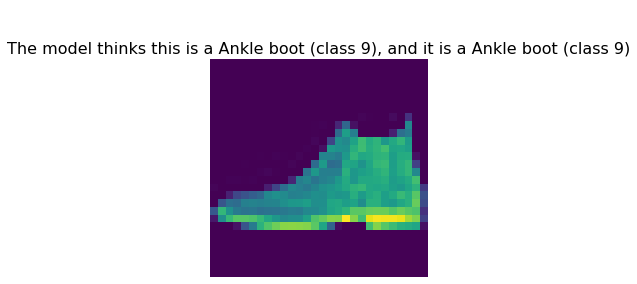

In [0]:
show(0, 'The model thinks this is a {} (class {}), and it is a {} (class {})'.format(
  class_names[np.argmax(predictions[0])], test_labels[0], class_names[np.argmax(predictions[0])], test_labels[0]))